# Linear Regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [26]:
class PerFeatureTransformer:
    def __init__(self):
        """Initializes memory for per-feature transformers."""
        self.transformers = {}
        self.feature_types = {}
        
    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        """
        Fits transformers for each feature based on the given type.
        """
        self.feature_types = params
        
        for feature, transform_type in self.feature_types.items():
            if feature not in df.columns:
                continue
                
            if transform_type == "standard":
                scaler = StandardScaler()
                scaler.fit(df[[feature]])
                self.transformers[feature] = scaler
                
            elif transform_type == "ordinal":
                encoder = OrdinalEncoder()
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
                
            elif transform_type == "onehot":
                encoder = OneHotEncoder(sparse_output=False, drop='first')
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
                
    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """Applies the fitted transformers to the corresponding features and returns a NumPy array."""
        transformed_features = []
        
        for feature, transform_type in self.feature_types.items():
            if feature not in df.columns:
                continue

            transformer = self.transformers[feature]
            transformed = transformer.transform(df[[feature]])
      
            if len(transformed.shape) == 2 and transformed.shape[1] > 1:
                transformed_features.append(transformed)
            else:
                transformed_features.append(transformed.reshape(-1, 1))
                
        return np.concatenate(transformed_features, axis=1)
    
    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        """Fits and transforms all features in one step using the given transformation parameters."""
        self.fit(df, params)
        return self.transform(df)

In [27]:
def run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test, 
                       degree=1, regularizer=None, reg_strength=0.0):
    """
    Fit a polynomial regression model with optional regularization.
    """
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)
    
    if regularizer is None:
        model = LinearRegression()
    elif regularizer == 'l1':
        model = Lasso(alpha=reg_strength, max_iter=2000)
    elif regularizer == 'l2':
        model = Ridge(alpha=reg_strength)
    else:
        raise ValueError("regularizer must be None, 'l1', or 'l2'")
    
    model.fit(X_train_poly, y_train)
    
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    y_test_pred = model.predict(X_test_poly)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    coefficients = model.coef_
    
    return {
        'train_mse': train_mse,
        'val_mse': val_mse,
        'test_mse': test_mse,
        'coefficients': coefficients,
        'feature_names': poly.get_feature_names_out(),
        'model': model,
        'poly_transformer': poly
    }

In [33]:
class GPAPredictor:
    def __init__(self, student_df: pd.DataFrame, username: str):
        """Initialize GPA predictor with student dataset."""
        self.df = student_df.copy()
        self.username = username
        self.feature_transformer = PerFeatureTransformer()
        
    def _watermark(self, ax):
        """Username in the plots"""
        ax.text(
            0.95, 0.95, self.username,
            ha='right', va='top',
            transform=ax.transAxes,
            fontsize=10, color='gray', alpha=0.7
        )
    
    def prepare_data_for_regression(self, test_size=0.2, val_size=0.2, seed=42):
        """Prepare data for regression by encoding categorical variables."""

        features = ['gender', 'major', 'program']
        X = self.df[features].copy()
        y = self.df['GPA'].values
  
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=seed
        )
        
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=seed
        )

        transform_params = {
            'gender': 'onehot',
            'major': 'onehot', 
            'program': 'onehot'
        }
        
        X_train_transformed = self.feature_transformer.fit_transform(X_train, transform_params)
        X_val_transformed = self.feature_transformer.transform(X_val)
        X_test_transformed = self.feature_transformer.transform(X_test)
        
        print(f"Data prepared:")
        print(f"Train: {X_train_transformed.shape[0]} samples, {X_train_transformed.shape[1]} features")
        print(f"Validation: {X_val_transformed.shape[0]} samples")
        print(f"Test: {X_test_transformed.shape[0]} samples")
        return X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test
    
    def analyze_polynomial_degrees(self, X_train, y_train, X_val, y_val, X_test, y_test, degrees=range(1, 7), regularizers=[None, 'l1', 'l2']):
        """Analyze polynomial regression across different degrees and regularizers."""

        results = {}        
        for regularizer in regularizers:
            print(f"\n=== Analyzing {regularizer if regularizer else 'No'} Regularization ===")
            reg_results = {
                'degrees': degrees,
                'train_mses': [],
                'val_mses': [],
                'test_mses': [],
                'best_configs': {}
            }

            for degree in degrees:
                result = run_poly_regression(
                    X_train, y_train, X_val, y_val, X_test, y_test,
                    degree=degree, regularizer=regularizer, reg_strength=0.01 if regularizer else 0.0
                )
                
                reg_results['train_mses'].append(result['train_mse'])
                reg_results['val_mses'].append(result['val_mse'])
                reg_results['test_mses'].append(result['test_mse'])
                
                print(f"Degree {degree}: Train MSE={result['train_mse']:.4f}, "
                      f"Val MSE={result['val_mse']:.4f}, Test MSE={result['test_mse']:.4f}")
            
            results[regularizer] = reg_results
            self.plot_degree_vs_mse(reg_results, regularizer)
        return results
    
    def plot_degree_vs_mse(self, results, regularizer_name):
        """Plot polynomial degree vs MSE for train and validation sets."""
        
        fig, ax = plt.subplots(figsize=(10, 6))
    
        ax.plot(results['degrees'], results['train_mses'], 'bo-', label='Training MSE', linewidth=2, markersize=8)
        ax.plot(results['degrees'], results['val_mses'], 'ro-', label='Validation MSE', linewidth=2, markersize=8)
        
        ax.set_xlabel('Polynomial Degree')
        ax.set_ylabel('Mean Squared Error')
        ax.set_title(f'Polynomial Degree vs MSE ({regularizer_name if regularizer_name else "No"} Regularization)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xticks(results['degrees'])
  
        best_degree_idx = np.argmin(results['val_mses'])
        best_degree = results['degrees'][best_degree_idx]
        best_val_mse = results['val_mses'][best_degree_idx]
        
        ax.plot(best_degree, best_val_mse, 'go', markersize=12, alpha=0.7)
        ax.annotate(f'Best degree={best_degree}\\nVal MSE={best_val_mse:.4f}', 
                   xy=(best_degree, best_val_mse), xytext=(10, 10), 
                   textcoords='offset points', fontsize=10,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
        
        self._watermark(ax)
        plt.tight_layout()
        plt.show()

        print(f"- Best degree: {best_degree} with validation MSE: {best_val_mse:.4f}")
        return best_degree, best_val_mse
    
    def tune_regularization_strength(self, X_train, y_train, X_val, y_val, X_test, y_test,
                                    best_degree, regularizer, reg_strengths=None):
        """Tune regularization strength for the best degree."""
        
        if reg_strengths is None:
            reg_strengths = np.logspace(-4, 2, 20) 
        
        val_mses = []
        test_mses = []
        
        print(f"\n=== Tuning {regularizer.upper()} Regularization Strength for Degree {best_degree} ===")
        
        for strength in reg_strengths:
            result = run_poly_regression(
                X_train, y_train, X_val, y_val, X_test, y_test,
                degree=best_degree, regularizer=regularizer, reg_strength=strength
            )
            val_mses.append(result['val_mse'])
            test_mses.append(result['test_mse'])
 
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.semilogx(reg_strengths, val_mses, 'bo-', linewidth=2, markersize=6, label='Validation MSE')
        ax.semilogx(reg_strengths, test_mses, 'ro-', linewidth=2, markersize=6, label='Test MSE')
        
        ax.set_xlabel('Regularization Strength (log scale)')
        ax.set_ylabel('Mean Squared Error')
        ax.set_title(f'{regularizer.upper()} Regularization Strength vs MSE (Degree {best_degree})')
        ax.legend()
        ax.grid(True, alpha=0.3)

        best_strength_idx = np.argmin(val_mses)
        best_strength = reg_strengths[best_strength_idx]
        best_val_mse = val_mses[best_strength_idx]
        
        ax.plot(best_strength, best_val_mse, 'go', markersize=12, alpha=0.7)
        ax.annotate(f'Best α={best_strength:.4f}\\nVal MSE={best_val_mse:.4f}', 
                   xy=(best_strength, best_val_mse), xytext=(10, 10), 
                   textcoords='offset points', fontsize=10,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
        
        self._watermark(ax)
        plt.tight_layout()
        plt.show()
        
        print(f"Best regularization strength: {best_strength:.6f}")
        print(f"Best validation MSE: {best_val_mse:.4f}")
        
        return best_strength, best_val_mse
    
    def analyze_feature_importance(self, X_train, y_train, X_val, y_val, X_test, y_test,
                                 best_degree, best_strength_l1, best_strength_l2):
        """Analyze feature importance for L1 and L2 regularization."""
        
        print("\n=== Feature Importance Analysis ===")
 
        print(f"\n--- L1 Regularization (α={best_strength_l1:.6f}) ---")
        l1_result = run_poly_regression(
            X_train, y_train, X_val, y_val, X_test, y_test,
            degree=best_degree, regularizer='l1', reg_strength=best_strength_l1
        )
    
        l1_coeffs = l1_result['coefficients']
        l1_features = l1_result['feature_names']
        l1_nonzero_mask = np.abs(l1_coeffs) > 1e-6
        l1_nonzero_coeffs = l1_coeffs[l1_nonzero_mask]
        l1_nonzero_features = l1_features[l1_nonzero_mask]
        
        print(f"Number of non-zero features: {len(l1_nonzero_coeffs)} out of {len(l1_coeffs)}")
        print("Non-zero features and their coefficients:")

        l1_importance_order = np.argsort(np.abs(l1_nonzero_coeffs))[::-1]
        for i in l1_importance_order[:10]:  
            print(f"  {l1_nonzero_features[i]}: {l1_nonzero_coeffs[i]:.4f}")

        print(f"\n--- L2 Regularization (α={best_strength_l2:.6f}) ---")
        l2_result = run_poly_regression(
            X_train, y_train, X_val, y_val, X_test, y_test,
            degree=best_degree, regularizer='l2', reg_strength=best_strength_l2
        )
        
        l2_coeffs = l2_result['coefficients']
        l2_features = l2_result['feature_names']
        
        print("All features with their coefficients (top 10 by absolute value):")
        l2_importance_order = np.argsort(np.abs(l2_coeffs))[::-1]
        for i in l2_importance_order[:10]:
            print(f"  {l2_features[i]}: {l2_coeffs[i]:.4f}")

        print(f"\n--- Comparison: L1 vs L2 Regularization ---")
        print(f"L1 Test MSE: {l1_result['test_mse']:.4f}")
        print(f"L2 Test MSE: {l2_result['test_mse']:.4f}")

        self.plot_coefficient_comparison(l1_result, l2_result, best_degree)
        return l1_result, l2_result
    
    def plot_coefficient_comparison(self, l1_result, l2_result, degree):
        """Plot comparison of L1 vs L2 coefficients."""
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        l1_coeffs = l1_result['coefficients']
        l1_features = l1_result['feature_names']
        nonzero_mask = np.abs(l1_coeffs) > 1e-6
        
        if np.sum(nonzero_mask) > 0:
            ax1.bar(range(np.sum(nonzero_mask)), l1_coeffs[nonzero_mask])
            ax1.set_title(f'L1 Regularization - Non-zero Coefficients\\n(Degree {degree})')
            ax1.set_xlabel('Feature Index')
            ax1.set_ylabel('Coefficient Value')
            ax1.grid(True, alpha=0.3)
   
        l2_coeffs = l2_result['coefficients']
        l2_features = l2_result['feature_names']
        top_indices = np.argsort(np.abs(l2_coeffs))[-20:]
        
        ax2.bar(range(20), l2_coeffs[top_indices])
        ax2.set_title(f'L2 Regularization - Top 20 Coefficients\\n(Degree {degree})')
        ax2.set_xlabel('Feature Index (Top 20)')
        ax2.set_ylabel('Coefficient Value')
        ax2.grid(True, alpha=0.3)
        
        self._watermark(ax1)
        self._watermark(ax2)
        plt.tight_layout()
        plt.show()

=== Polynomial Regression Analysis for GPA Prediction ===
Data prepared:
Train: 6000 samples, 7 features
Validation: 2000 samples
Test: 2000 samples

=== Analyzing No Regularization ===
Degree 1: Train MSE=0.8145, Val MSE=0.8432, Test MSE=0.7982
Degree 2: Train MSE=0.8118, Val MSE=0.8441, Test MSE=0.8015
Degree 3: Train MSE=0.8112, Val MSE=0.8465, Test MSE=0.8012
Degree 4: Train MSE=0.8112, Val MSE=0.8465, Test MSE=0.8012
Degree 5: Train MSE=0.8112, Val MSE=0.8465, Test MSE=0.8012
Degree 6: Train MSE=0.8112, Val MSE=0.8465, Test MSE=0.8012


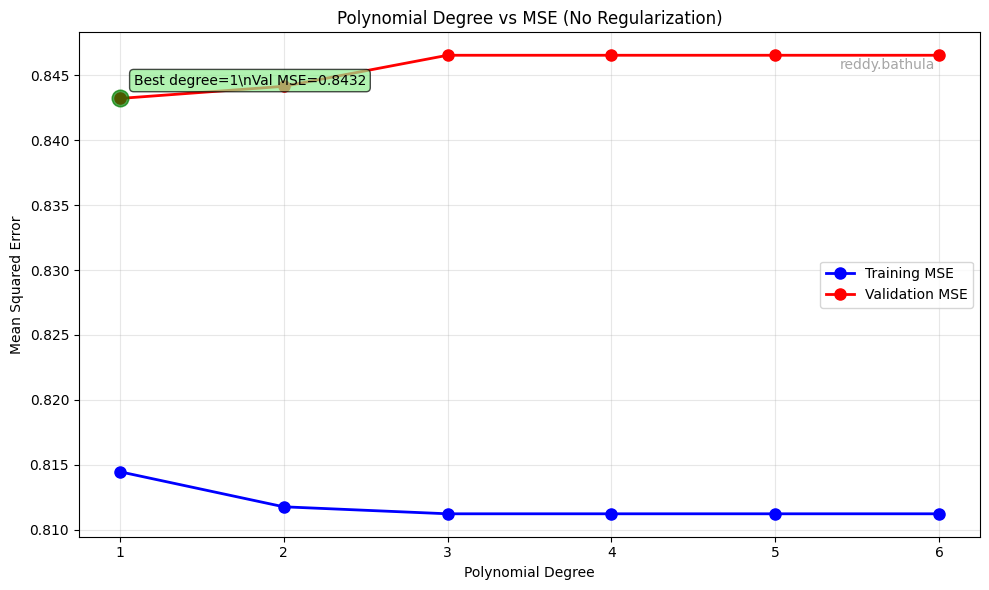

- Best degree: 1 with validation MSE: 0.8432

=== Analyzing l1 Regularization ===
Degree 1: Train MSE=0.8170, Val MSE=0.8452, Test MSE=0.8002
Degree 2: Train MSE=0.8170, Val MSE=0.8452, Test MSE=0.8002
Degree 3: Train MSE=0.8170, Val MSE=0.8452, Test MSE=0.8002
Degree 4: Train MSE=0.8170, Val MSE=0.8452, Test MSE=0.8002
Degree 5: Train MSE=0.8170, Val MSE=0.8452, Test MSE=0.8002
Degree 6: Train MSE=0.8170, Val MSE=0.8452, Test MSE=0.8002


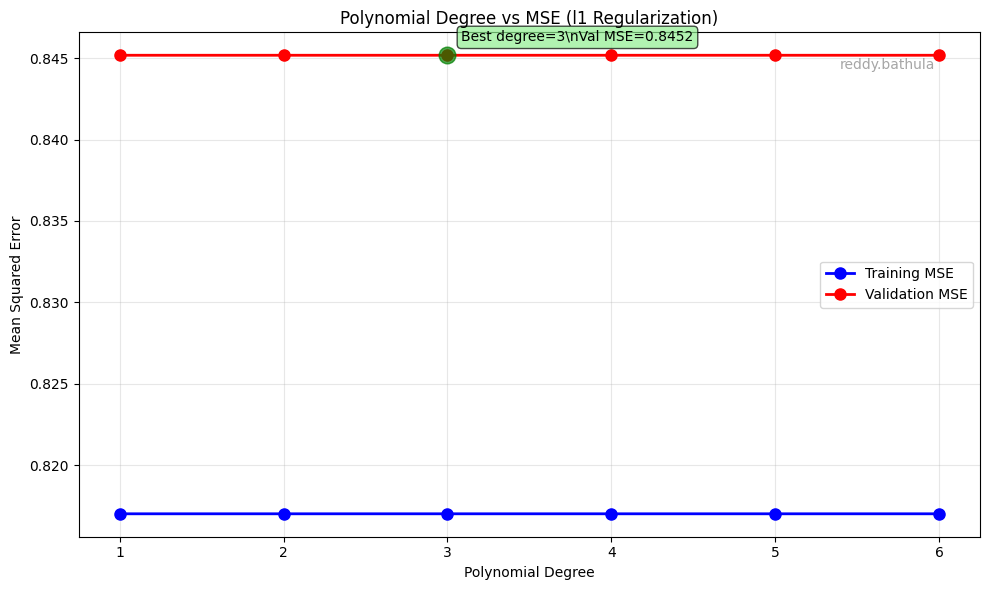

- Best degree: 3 with validation MSE: 0.8452

=== Analyzing l2 Regularization ===
Degree 1: Train MSE=0.8145, Val MSE=0.8432, Test MSE=0.7982
Degree 2: Train MSE=0.8118, Val MSE=0.8441, Test MSE=0.8015
Degree 3: Train MSE=0.8112, Val MSE=0.8465, Test MSE=0.8012
Degree 4: Train MSE=0.8112, Val MSE=0.8465, Test MSE=0.8012
Degree 5: Train MSE=0.8112, Val MSE=0.8465, Test MSE=0.8012
Degree 6: Train MSE=0.8112, Val MSE=0.8465, Test MSE=0.8012


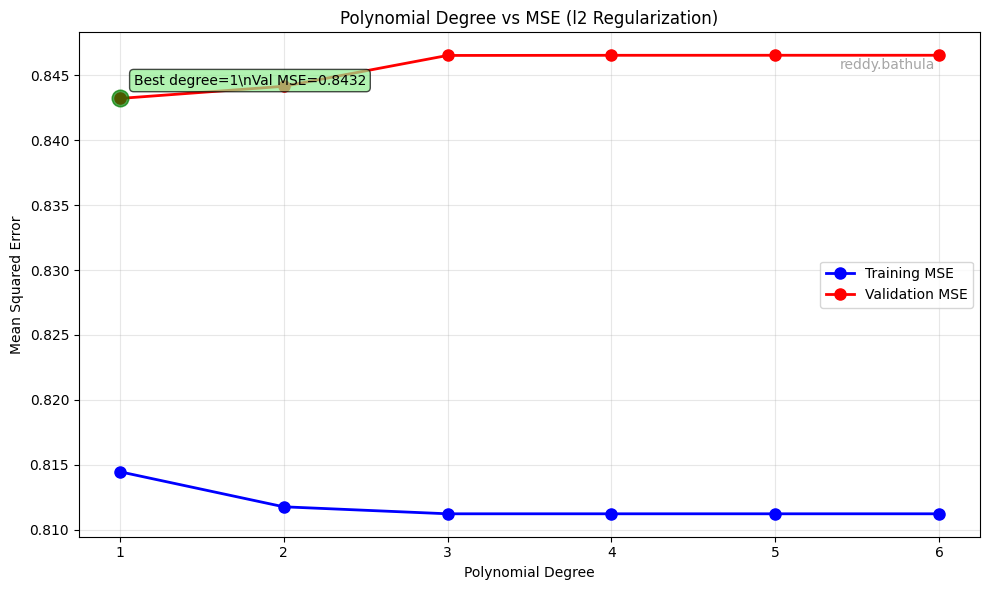

- Best degree: 1 with validation MSE: 0.8432


In [34]:
print("=== Polynomial Regression Analysis for GPA Prediction ===")

df = pd.read_csv('student_dataset.csv')  
gpa_predictor = GPAPredictor(df, "reddy.bathula")

X_train, X_val, X_test, y_train, y_val, y_test = gpa_predictor.prepare_data_for_regression()
degrees = list(range(1, 7))
regularizers = [None, 'l1', 'l2']
results = gpa_predictor.analyze_polynomial_degrees(X_train, y_train, X_val, y_val, X_test, y_test, degrees=degrees, regularizers=regularizers)

- Trends:
    - No  Regularization
        - MSE decreased and stabilized with increasing degree for training.
        - MSE increased and stabilized with increasing degree for validation.
    - L1
        - MSE was stable with both training and validation.
    - L2
        - MSE decreased and stabilized with increasing degree for training.
        - MSE increased and stabilized with increasing degree for validation.


REGULARIZATION STRENGTH TUNING

Best degree for L1: 3

=== Tuning L1 Regularization Strength for Degree 3 ===


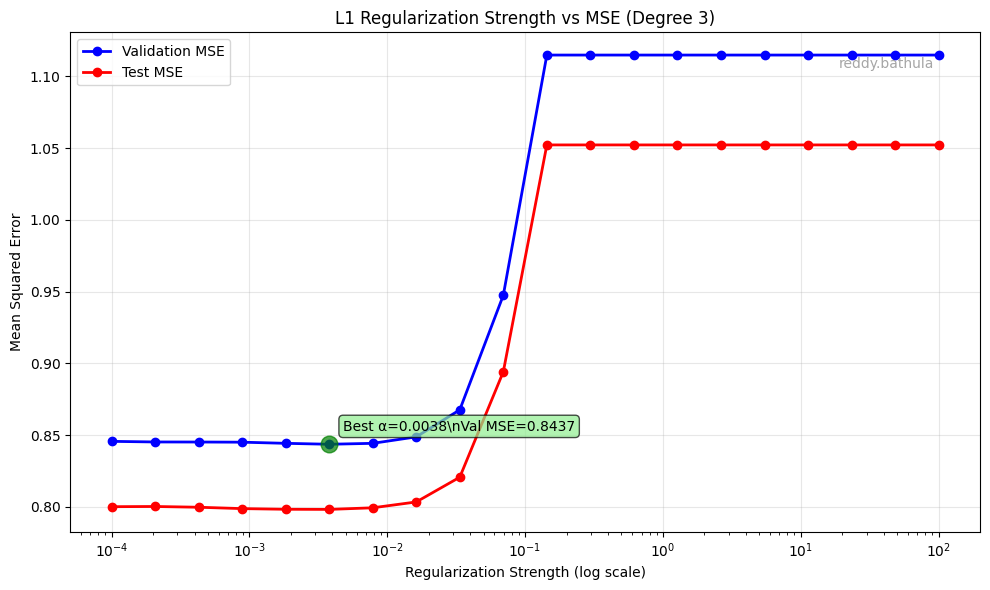

Best regularization strength: 0.003793
Best validation MSE: 0.8437

Best degree for L2: 1

=== Tuning L2 Regularization Strength for Degree 1 ===


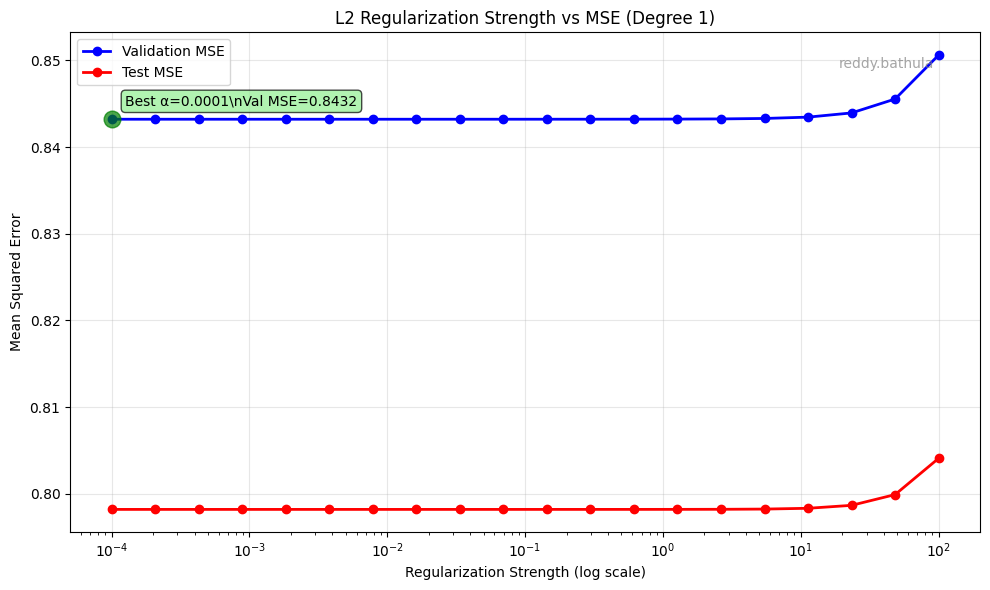

Best regularization strength: 0.000100
Best validation MSE: 0.8432


In [35]:
print("\n" + "="*60)
print("REGULARIZATION STRENGTH TUNING")
print("="*60)

best_configurations = {}

for regularizer in ['l1', 'l2']:
    reg_results = results[regularizer]
    best_degree_idx = np.argmin(reg_results['val_mses'])
    best_degree = reg_results['degrees'][best_degree_idx]
    
    print(f"\nBest degree for {regularizer.upper()}: {best_degree}")

    best_strength, best_val_mse = gpa_predictor.tune_regularization_strength(
        X_train, y_train, X_val, y_val, X_test, y_test,
        best_degree, regularizer
    )

    best_configurations[regularizer] = {
        'degree': best_degree,
        'reg_strength': best_strength,
        'val_mse': best_val_mse
    }

no_reg_results = results[None]
best_no_reg_idx = np.argmin(no_reg_results['val_mses'])
best_configurations[None] = {
    'degree': no_reg_results['degrees'][best_no_reg_idx],
    'reg_strength': 0.0,
    'val_mse': no_reg_results['val_mses'][best_no_reg_idx]
}

In [37]:
print("\n" + "="*60)
print("FINAL PERFORMANCE COMPARISON")
print("="*60)

final_test_results = {}

for reg_name, config in best_configurations.items():
    test_result = run_poly_regression(
        X_train, y_train, X_val, y_val, X_test, y_test,
        degree=config['degree'],
        regularizer=reg_name,
        reg_strength=config['reg_strength']
    )
    
    final_test_results[reg_name] = test_result
    
    reg_display = reg_name.upper() if reg_name else "None"
    print(f"\n{reg_display} Regularization:")
    print(f"  Degree: {config['degree']}")
    print(f"  Reg Strength: {config['reg_strength']:.6f}")
    print(f"  Validation MSE: {config['val_mse']:.6f}")
    print(f"  Test MSE: {test_result['test_mse']:.6f}")

best_test_mse = float('inf')
best_overall_config = None

for reg_name, result in final_test_results.items():
    if result['test_mse'] < best_test_mse:
        best_test_mse = result['test_mse']
        best_overall_config = reg_name

reg_display = best_overall_config.upper() if best_overall_config else "None"
print(f"\nBEST OVERALL PERFORMANCE: {reg_display} Regularization")
print(f"   Test MSE: {best_test_mse:.6f}")
print(f"   Configuration: {best_configurations[best_overall_config]}")

print(f"\n--- Performance Analysis ---")
no_reg_mse = final_test_results[None]['test_mse']
l1_mse = final_test_results['l1']['test_mse']
l2_mse = final_test_results['l2']['test_mse']

if l1_mse < no_reg_mse or l2_mse < no_reg_mse:
    print("Regularization improves performance!")
    if l1_mse < l2_mse:
        improvement = ((no_reg_mse - l1_mse) / no_reg_mse) * 100
        print(f"   L1 regularization gives best results ({improvement:.2f}% improvement)")
    else:
        improvement = ((no_reg_mse - l2_mse) / no_reg_mse) * 100
        print(f"   L2 regularization gives best results ({improvement:.2f}% improvement)")
else:
    print("Regularization does not improve performance in this case")
    print("This might be due to sufficient data or simple relationships")


FINAL PERFORMANCE COMPARISON

L1 Regularization:
  Degree: 3
  Reg Strength: 0.003793
  Validation MSE: 0.843654
  Test MSE: 0.798263

L2 Regularization:
  Degree: 1
  Reg Strength: 0.000100
  Validation MSE: 0.843210
  Test MSE: 0.798183

None Regularization:
  Degree: 1
  Reg Strength: 0.000000
  Validation MSE: 0.843210
  Test MSE: 0.798183

BEST OVERALL PERFORMANCE: None Regularization
   Test MSE: 0.798183
   Configuration: {'degree': 1, 'reg_strength': 0.0, 'val_mse': 0.8432099656693707}

--- Performance Analysis ---
Regularization does not improve performance in this case
This might be due to sufficient data or simple relationships



FEATURE IMPORTANCE ANALYSIS
Analyzing feature importance at degree 3

=== Feature Importance Analysis ===

--- L1 Regularization (α=0.003793) ---
Number of non-zero features: 12 out of 119
Non-zero features and their coefficients:
  x3: 1.2379
  x2: 0.7952
  x2^2: 0.1563
  x3^2: 0.0341
  x0 x4: 0.0177
  x0^2 x5: 0.0106
  x0 x5: 0.0081
  x2^3: 0.0049
  x3^3: 0.0021
  x0 x4^2: 0.0016

--- L2 Regularization (α=0.000100) ---
All features with their coefficients (top 10 by absolute value):
  x1 x2 x4: 1.0126
  x1 x2 x6: 0.8484
  x1 x2 x5: 0.4939
  x3^3: 0.4669
  x3: 0.4669
  x3^2: 0.4669
  x2^2: 0.3840
  x2^3: 0.3840
  x2: 0.3840
  x1 x4^2: -0.3111

--- Comparison: L1 vs L2 Regularization ---
L1 Test MSE: 0.7983
L2 Test MSE: 0.8012


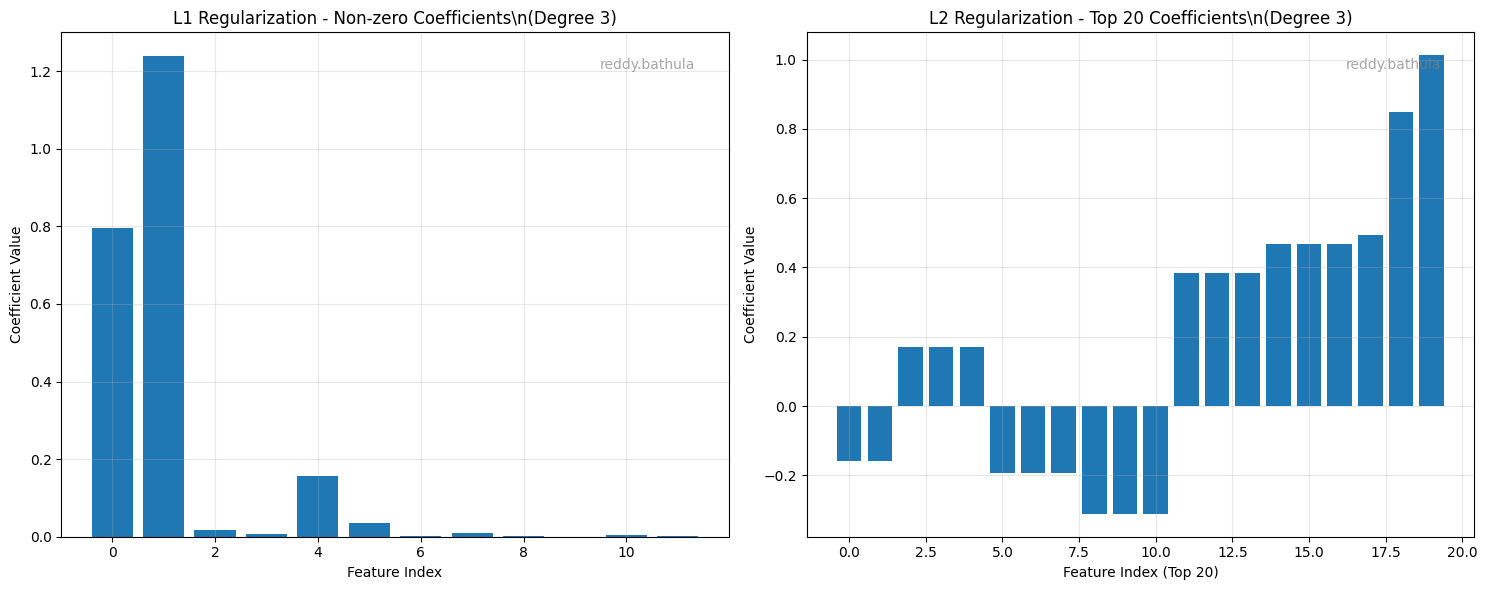

In [32]:
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

best_degree_l1 = best_configurations['l1']['degree']
best_degree_l2 = best_configurations['l2']['degree']
best_strength_l1 = best_configurations['l1']['reg_strength']
best_strength_l2 = best_configurations['l2']['reg_strength']

analysis_degree = max(best_degree_l1, best_degree_l2)

print(f"Analyzing feature importance at degree {analysis_degree}")

l1_result, l2_result = gpa_predictor.analyze_feature_importance(
    X_train, y_train, X_val, y_val, X_test, y_test,
    analysis_degree, best_strength_l1, best_strength_l2
)


- L2 was slightly better than L1